In [1]:
#!pip install dataprep

In [2]:
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import os
import joblib
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
img_width, img_height = 256, 256
batchsize = 32
epochs = 10
num_of_class = 2
train = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

Found 5216 files belonging to 2 classes.


In [4]:
img_width, img_height = 256, 256
batchsize = 32
epochs = 10
num_of_class = 2
test = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

Found 624 files belonging to 2 classes.


In [5]:
img_width, img_height = 256, 256
batchsize = 32
epochs = 10
num_of_class = 2
validation = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

Found 16 files belonging to 2 classes.


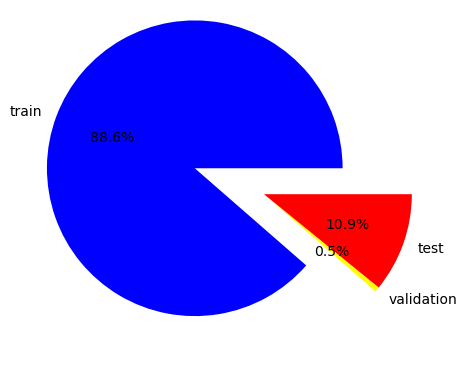

In [6]:
plt.pie([len(train), len(validation), len(test)], 
labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['blue','yellow','red'], explode=(0.5, 0, 0))
plt.show()

/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


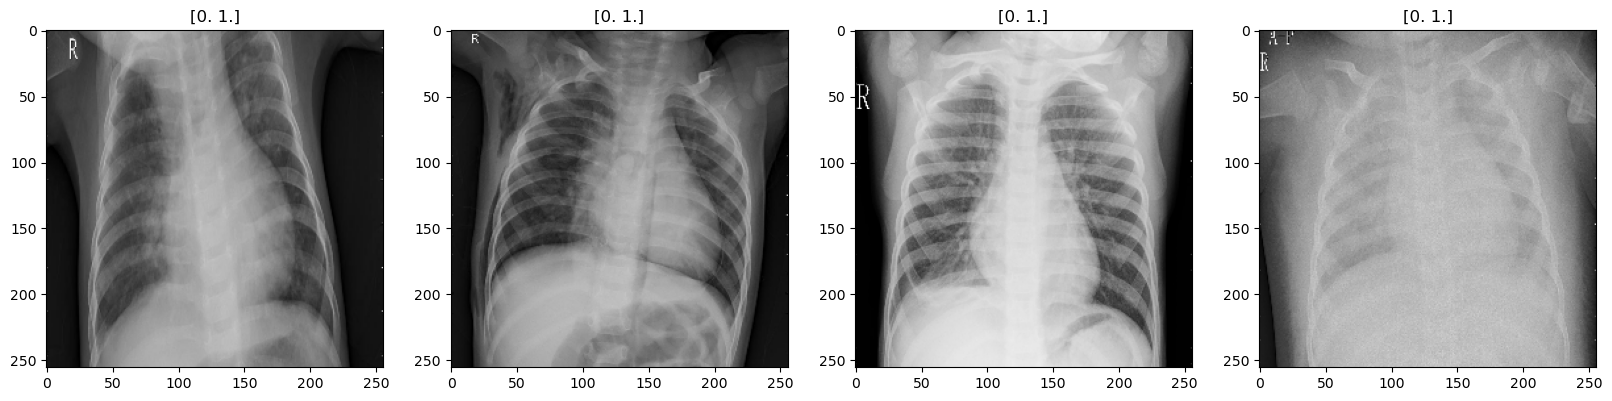

In [7]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [8]:
xtrain = []
ytrain = []
xval = []
yval = []
xtest = []
ytest = []

for feature, label in train:
    xtrain.append(feature.numpy())
    ytrain.append(label.numpy())

for feature, label in test:
    xtest.append(feature.numpy())
    ytest.append(label.numpy())
    
for feature, label in validation:
    xval.append(feature.numpy())
    yval.append(label.numpy())


xtrain = np.concatenate(xtrain, axis=0)
xval = np.concatenate(xval, axis=0)
xtest = np.concatenate(xtest, axis=0)
ytrain = np.concatenate(ytrain, axis=0)
yval = np.concatenate(yval, axis=0)
ytest = np.concatenate(ytest, axis=0)

In [9]:
print("Shape of 'x_train':", xtrain.shape)
print("Shape of 'y_train':", ytrain.shape)
print("Shape of 'x_val':", xval.shape)
print("Shape of 'y_val':", yval.shape)
print("Shape of 'x_test':", xtest.shape)
print("Shape of 'y_test':", ytest.shape)

Shape of 'x_train': (5216, 256, 256, 3)
Shape of 'y_train': (5216, 2)
Shape of 'x_val': (16, 256, 256, 3)
Shape of 'y_val': (16, 2)
Shape of 'x_test': (624, 256, 256, 3)
Shape of 'y_test': (624, 2)


In [10]:
xtrain=xtrain/256
xval=xval/256
xtest=xtest/256

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                         

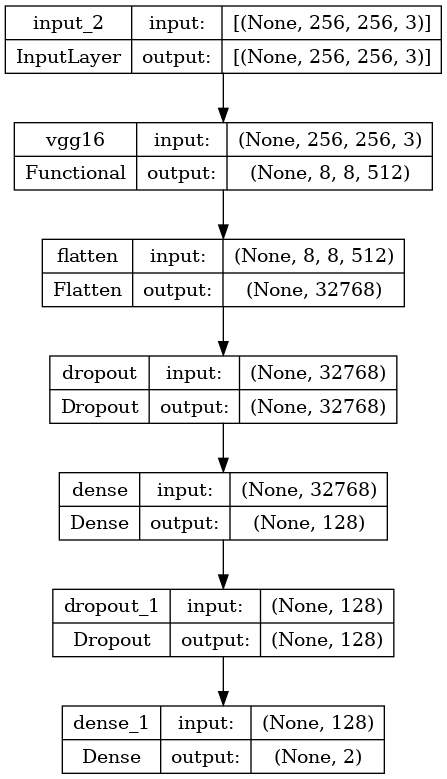

In [11]:
def CNN_Model():
    base_model = VGG16(weights='imagenet', include_top = False, input_shape=(img_width, img_height, 3))
    
    for layer in base_model.layers:
        layer.trainable = False

    for i in range(3):
        base_model.layers[-2-i].trainable = True

    CNN = Sequential()
    CNN.add(Input(shape=(img_width, img_height,3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dropout(0.3))
    CNN.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(2, activation='sigmoid'))
    
    return CNN


model = CNN_Model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()  

keras.utils.plot_model(model, show_shapes=True)

In [12]:
hist = model.fit(xtrain, ytrain, epochs= 10, validation_data= (xval, yval))
print(hist.history)
best_score = max(hist.history['val_accuracy'])
print(f"Best Validation score is: {best_score}")

Epoch 1/10
163/163 [==============================] - 2350s 14s/step - loss: 1.3007 - accuracy: 0.7954 - val_loss: 0.4135 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 2339s 14s/step - loss: 0.2794 - accuracy: 0.9367 - val_loss: 0.2841 - val_accuracy: 0.9375
Epoch 3/10
163/163 [==============================] - 2327s 14s/step - loss: 0.1602 - accuracy: 0.9613 - val_loss: 0.3433 - val_accuracy: 0.9375
Epoch 4/10
163/163 [==============================] - 2367s 15s/step - loss: 0.1433 - accuracy: 0.9655 - val_loss: 0.2655 - val_accuracy: 0.9375
Epoch 5/10
163/163 [==============================] - 2409s 15s/step - loss: 0.1092 - accuracy: 0.9770 - val_loss: 0.0919 - val_accuracy: 1.0000
Epoch 6/10
163/163 [==============================] - 2382s 15s/step - loss: 0.0923 - accuracy: 0.9806 - val_loss: 0.0465 - val_accuracy: 1.0000
Epoch 7/10
163/163 [==============================] - 2389s 15s/step - loss: 0.0564 - accuracy: 0.9881 - val_loss: 0.0535 - val_ac

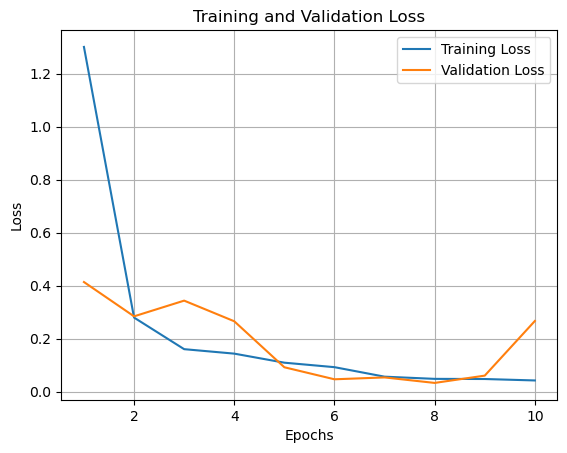

In [13]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

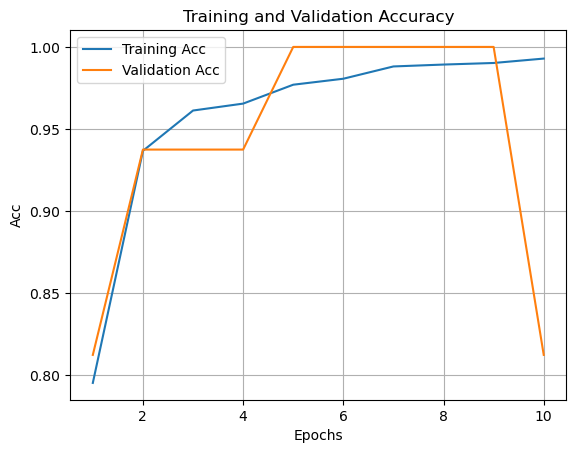

In [15]:
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
model.save('CNN_model.h5')
print ("Model saved successfully!")

Model saved successfully!


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 18,909,378
Trainable params: 11,274,114
No